In [23]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
candidates = pd.read_csv("candidates.csv")

In [24]:
%%time
candidates.columns = map(str.lower, candidates.columns)
del candidates[candidates.columns[0]]
candidates.link=candidates.link.apply(lambda x: x[27:])
le = preprocessing.LabelEncoder()
le.fit(candidates.constituency)
candidates['constituency_']=le.transform(candidates.constituency)
le.fit(candidates.party)
candidates['party_']=le.transform(candidates.party)
le.fit(candidates.name)
candidates['name_']=le.transform(candidates.name)
#le.fit(candidates.state)
#candidates['state_']=le.transform(candidates.state)
le.fit(candidates.education)
candidates['education_']=le.transform(candidates.education)

c = pd.get_dummies(candidates.state, prefix = "state")
candidates = candidates.join(c)
#c = pd.get_dummies(candidates.education)
#candidates = candidates.join(c)
for i,r in candidates.iterrows():
    try:
        #r.assets_rs=int(r.assets_rs)
        candidates.loc[i, 'assets_rs'] = int(r.assets_rs)
    except:
        candidates.loc[i, 'assets_rs'] = int(0)

CPU times: user 22.3 s, sys: 16 ms, total: 22.3 s
Wall time: 22.3 s


In [25]:
#features to be used for training-
features=candidates.columns-['constituency','education','party','name','state','winner','year','link']
#features to be used later for visualisations-
v=['assets_rs','liabilities_rs','constituency','education','party','name','state','winner','year']
target=['winner']
print "Total features to train: " + str(len(features))

Total features to train: 46


/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  from ipykernel import kernelapp as app


In [26]:
from sklearn import cross_validation
from time import time
from sklearn.metrics import f1_score
# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test = cross_validation.train_test_split(candidates, test_size=0.2)
# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 15308 samples.
Testing set has 3827 samples.


In [27]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = GradientBoostingClassifier(random_state=0)
clf_C = NearestCentroid()

In [29]:
train_predict(clf_A, X_train[features], X_train[target], X_test[features], X_test[target])
train_predict(clf_B, X_train[features], X_train[target], X_test[features], X_test[target])
train_predict(clf_C, X_train[features], X_train[target], X_test[features], X_test[target])

Training a DecisionTreeClassifier using a training set size of 15308. . .
Trained model in 0.1775 seconds
Made predictions in 0.0489 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0111 seconds.
F1 score for test set: 0.4729.
Training a GradientBoostingClassifier using a training set size of 15308. . .


/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trained model in 2.6563 seconds
Made predictions in 0.1039 seconds.
F1 score for training set: 0.4315.
Made predictions in 0.0209 seconds.
F1 score for test set: 0.4077.
Training a NearestCentroid using a training set size of 15308. . .
Trained model in 0.0517 seconds
Made predictions in 0.0531 seconds.
F1 score for training set: 0.2539.
Made predictions in 0.0119 seconds.
F1 score for test set: 0.2667.


/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
feat={}
for i,j in zip(features,clf_A.feature_importances_):
    feat[i]=j
df=pd.DataFrame(feat.items(), columns=['name', 'value'])
df=df.sort_values('value', axis=0,ascending=False)

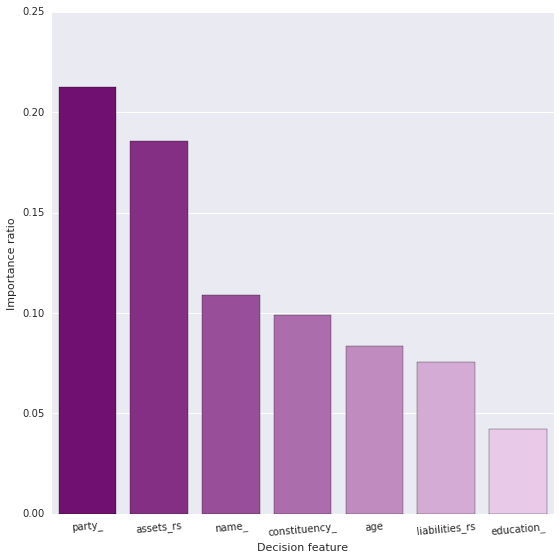

In [31]:
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 9))
ax=sns.barplot(x="name", y="value",data=df[:7], palette=sns.light_palette("purple", reverse=True,n_colors=8))
for item in ax.get_xticklabels():
    item.set_rotation(5)
ax.set(xlabel='Decision feature', ylabel='Importance ratio')

### Check difference in assets and liabilities 5 years after winning-

In [94]:
candidates=candidates[v]
winners = candidates[candidates.winner != 0]
winner_2004 = winners[winners.year == 2004]
winner_2009 = winners[winners.year == 2009]

In [95]:
df = pd.DataFrame()
df2 = pd.DataFrame()
for i in winner_2004.name:
    df=df.append(candidates.loc[candidates['name'] == i])
df=df[df.year == 2009]
for i in winner_2009.name:
    df2=df2.append(candidates.loc[candidates['name'] == i])
df2=df2[df2.year == 2014]


In [99]:
i=df.set_index(['name']).assets_rs-winner_2004.set_index(['name']).assets_rs
j=df.set_index(['name']).liabilities_rs-winner_2004.set_index(['name']).liabilities_rs
i=i[~i.isnull()]
j=j[~j.isnull()]
print "Average change in assets of winners of 2004 =",i.mean()
print "Average change in liabilities of winners of 2004 =",j.mean()
print "Average money gained = Rs.",i.mean()-j.mean()

Average change in assets of winners of 2004 = 34460307.2092
Average change in liabilities of winners of 2004 = 702747.254902
Average money gained = Rs. 33757559.9542


In [101]:
i=df2.set_index(['name']).assets_rs-winner_2009.set_index(['name']).assets_rs
j=df2.set_index(['name']).liabilities_rs-winner_2009.set_index(['name']).liabilities_rs
i=i[~i.isnull()]
j=j[~j.isnull()]
print "Average change in assets of winners of 2009 =",i.mean()
print "Average change in liabilities of winners of 2009 =",j.mean()
print "Average money gained = Rs.",i.mean()-j.mean()

Average change in assets of winners of 2009 = 55268498.3095
Average change in liabilities of winners of 2009 = 8466335.88095
Average money gained = Rs. 46802162.4286


In [113]:
print "Education level of winners of 2004- "
print pd.value_counts(winner_2004.education.ravel())

Education level of winners of 2009- 
Graduate                 135
Post Graduate            128
Graduate Professional    107
12th Pass                 51
10th Pass                 48
Doctorate                 23
5th Pass                   9
8th Pass                   8
Others                     6
Literate                   5
dtype: int64


In [114]:
print "Education level of winners of 2009- "
print pd.value_counts(winner_2009.education.ravel())

Education level of winners of 2009- 
Graduate                 135
Post Graduate            128
Graduate Professional    107
12th Pass                 51
10th Pass                 48
Doctorate                 23
5th Pass                   9
8th Pass                   8
Others                     6
Literate                   5
dtype: int64
